<a href="https://colab.research.google.com/github/michiko-tamon/OII-Statistics/blob/main/notebooks/example-2/example-2-answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example 2
=========

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find
errors or would like to suggest an improvement, feel free to create an
issue.

As usual we will start by importing some useful libraries.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The data in `data-auto.csv` is a popular dataset of car characteristics. We will be looking at the horsepower and miles per gallon (MPG) obtained by these cars. The model we will consider in this notebook is a simple linear regression:

$$
\text{mpg}_{i} = \alpha + \beta \text{horsepower}_{i} + \epsilon_{i}
$$

where the $\epsilon_{i}$ are IID normal fluctuations. We will estimate the parameters $\alpha$ and $\beta$.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Statistics-with-Python/AAS-MT2021/main/notebooks/example-2/data-auto.csv")

y = df["mpg"].to_numpy()
x = df["horsepower"].to_numpy()
y_bar = y.mean()
x_bar = x.mean()

### Question

Plot the horsepower and MPG, describe the relationship between these variables.

### Answer

As the horsepower increases the car gets fewer MPG.

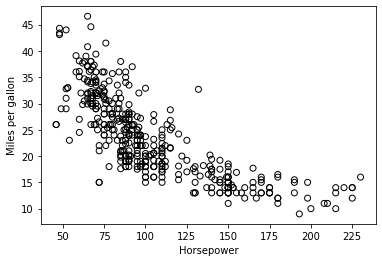

In [3]:
plt.figure()
plt.scatter(x, y, marker='o', facecolor='none', edgecolor='k') #markers are made hallow so the points behind can be seen, can also use opactiy  
plt.xlabel("Horsepower") 
plt.ylabel("Miles per gallon")
plt.show()

### Question

Using the formula you saw in lectures, calculate the least squares estimates $\hat{\beta}$ and $\hat{\alpha}$

### Answer

In [11]:
#formula from lecture (xi-x_bar)dot(yi-y_bar)/sum (xi-xbar)ˆ2
beta_hat = np.sum((x - x_bar) * (y - y_bar)) / np.sum((x - x_bar) * (x - x_bar)) 
alpha_hat = y_bar - beta_hat * x_bar

### Question

Using your parameter estimates, calculate the expected values for the MPG, $\hat{y}_{i}$, and the residuals, $e_{i}$.

### Answer

In [5]:
#simple linear formula to calculate y_hat from estimated a and b 
y_hat = alpha_hat + beta_hat * x
#resudial is the remainder between real y and estimated y
residuals = y - y_hat

### Question

Plot the model fit and the residuals. Are the assumptions (linearity, constant variance and independenc) of the model valid? What does the model predict would be the MPG for a car with the power of 400 horses?

### Answer

The MPG does not vary linearly with the horsepower, we will learn how to address this later in the course. Extending the regression to a horsepower of 400 produces a negative estimate of MPG which clearly does not make sense.

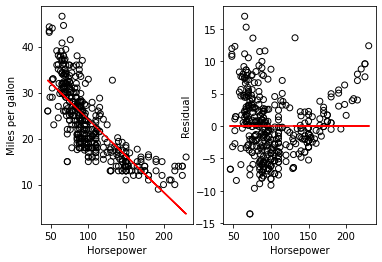

In [12]:
fig, axs = plt.subplots(1, 2)
#plot the actual OLS 
#assumption 1. Linearity - expected error = 0 2. Resudial has constant variance 3. Residual is independent of each other  
axs[0].scatter(x, y, marker='o', facecolor='none', edgecolor='k')
axs[0].plot(x, y_hat, color='r')
axs[0].set_xlabel("Horsepower")
axs[0].set_ylabel("Miles per gallon")

#plot the residual to see if they are normal 
axs[1].scatter(x, residuals, marker='o', facecolor='none', edgecolor='k')
axs[1].plot(x, np.repeat(0, x.size), color='r')
axs[1].set_xlabel("Horsepower")
axs[1].set_ylabel("Residual")
fig.show()

### Question

Calculate the correlation coeffient, and $R^{2}$.

### Answer

In [17]:
corr_coef = np.sum((x - x_bar) * (y - y_bar)) / (np.sqrt(np.sum((x - x_bar) * (x - x_bar))) * np.sqrt(np.sum((y - y_bar) * (y - y_bar))))

total_sum_sqrs = np.sum((y - y_bar)**2) #total sum squared
reg_sum_sqrs = np.sum((y_hat - y_bar)**2) #regression sum squared
res_sum_sqrs = np.sum((y - y_hat)**2) #residual sum squared
#propability of variance explained by the regression 
r_sqrd = 1 - res_sum_sqrs / total_sum_sqrs #Rˆ2 = residual sum squared / total sum squared 

print(r_sqrd) #depending on the spread of the data, Rˆ2 can be very high despite model not fitting well 
print(corr_coef**2) # R-Squared is the square of the correlation coefficient, r (hence the term r squared)

0.6059482578894348
0.6059482578894345


### Question

Calculate the confidence intervals on your estimates. Is the result significant?

### Answer

We use the _t_-distribution with $n-2$ degrees of freedom to compute the confidence intervals because we needed to estimate the residual standard error and two degrees of freedom where used to estimate the coefficients of the linear model.

Yes, the coefficients are both significantly different from zero.

In [18]:
n = df.shape[0]
sigma_hat = np.sqrt(res_sum_sqrs / (n - 2)) #estimate sigma hat because you have two variables 

s_x = np.sum(x**2)
s_xx = np.sum((x - x_bar)**2)

var_beta_hat = sigma_hat**2 / s_xx

var_alpha_hat = sigma_hat**2 * s_x / (n * s_xx)

t_val = stats.t.ppf(0.975, df = n-2) #use t distribution because we are doing

alpha_ci = (
    alpha_hat - t_val * np.sqrt(var_alpha_hat),
    alpha_hat + t_val * np.sqrt(var_alpha_hat)
)

beta_ci = (
    beta_hat - t_val * np.sqrt(var_beta_hat),
    beta_hat + t_val * np.sqrt(var_beta_hat)
)

print(alpha_ci) #confidence interval of A
print(beta_ci) #confidence interval of B

(38.525211789229616, 41.34651025311132)
(-0.17051700846435697, -0.14517245824295028)


### `statsmodels`

We are finally ready to use the `statsmodel` package. In the following code we perform ordinary least squares regression and print out a summary. You can see that all of the estimates agree with those we calculated above.

In [21]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [ ]:
#fit OLS using model and you don't have to calculate the value yourself 
my_lm = smf.ols("mpg ~ horsepower", df).fit() #specify model you want to fit with the string 
#mpg is y and horsepower is x 
print(my_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 02 Nov 2021   Prob (F-statistic):           7.03e-81
Time:                        19:44:45   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.0